# Open problems - Single cell perturbations
## Model Ensembling
#### by Antoine Passemiers and Jalil Nourisa

In this notebook we combine multiple submissions into a final submission file. While most solutions consist in computing a weighted average of the submissions using arbitrarily-defined weights, we tried instead to devise a more principled approach for ensembling.

In [1]:
import os
import random
import collections

import tqdm
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

Let's first load the training DE data, as we need it for quantifying gene variances.

In [2]:
# Data location
DATA_FOLDER = '/kaggle/input/open-problems-single-cell-perturbations/'

# Cell types for which all compounds are available in training set
TRAIN_CELL_TYPES = ['NK cells', 'T cells CD4+', 'T cells CD8+', 'T regulatory cells']

# Cell types for which some compounds are available in test set
TEST_CELL_TYPES = ['Myeloid cells', 'B cells']

# All cell types
CELL_TYPES = TRAIN_CELL_TYPES + TEST_CELL_TYPES

# Load DE data, as well as the cell type, compound and SMILES for each row
df = pd.read_parquet(os.path.join(DATA_FOLDER, 'de_train.parquet'))
cell_types = df['cell_type']
sm_names = df['sm_name']
all_smiles = df['SMILES']

# Convert Pandas dataframe to NumPy array
for col_name in ['cell_type', 'sm_name', 'sm_lincs_id', 'SMILES', 'control']:
    df.drop(col_name, axis=1, inplace=True)
data = df.to_numpy(dtype=float)

# Gene names, ordered by columns
gene_names = list(df.columns)
gene_name_dict = {gene_name: i for i, gene_name in enumerate(gene_names)}

# Unique compound names and cell types
unique_sm_names = list(set(sm_names))
unique_cell_types = list(set(cell_types))

# Set seed for reproducibility purposes
SEED = 0xCAFE
random.seed(SEED)
np.random.seed(SEED)

We now load our submissions, composed of a neural network trained with different number of epochs (respectively 40 and 200), and a neural network with sparsified layers based on biological networks. Additionally, we load a submission coming from a public blend: [https://www.kaggle.com/code/jeanlucvanlite/only-lb-dont-select-as-final-submission-ensembling](#https://www.kaggle.com/code/jeanlucvanlite/only-lb-dont-select-as-final-submission-ensembling).

Let's note that for this version of the notebook, <span style="color:crimson;">we don't use the public blend in our final predictions.</span>

In [3]:
EXTRA_FOLDER = '/kaggle/input/op2-submissions'

# Jalil's local ensemble
#df_jalil = pd.read_csv(os.path.join(EXTRA_FOLDER, 'jalil.csv'), index_col='id')

# Version 15 of https://www.kaggle.com/code/antoinepassemiers/op2-de-dl
df_dl40 = pd.read_csv(os.path.join(EXTRA_FOLDER, 'dl40.csv'), index_col='id')
df_dl200 = pd.read_csv(os.path.join(EXTRA_FOLDER, 'op2-de-dl.csv'), index_col='id')

# df_dl_gene_cat = pd.read_csv(os.path.join(EXTRA_FOLDER, 'op2-dl-with-gene-categories.csv'), index_col='id')

df_dl_bio_nets = pd.read_csv(os.path.join(EXTRA_FOLDER, 'op2-dl-with-bio-nets.csv'), index_col='id')

#df_gnn = pd.read_csv(os.path.join(EXTRA_FOLDER, 'op2-de-gnn.csv'), index_col='id')

# Version 7 of https://www.kaggle.com/antoinepassemiers/op2-rf
#df_rf = pd.read_csv(os.path.join(EXTRA_FOLDER, 'op2-tree-ensembles.csv'), index_col='id')

#df_gbm = pd.read_csv(os.path.join(EXTRA_FOLDER, 'gbm.csv'), index_col='id')

#df_linear = pd.read_csv(os.path.join(EXTRA_FOLDER, 'linear.csv'), index_col='id')

# https://www.kaggle.com/code/jeanlucvanlite/only-lb-dont-select-as-final-submission-ensembling
df_public = pd.read_csv(os.path.join(EXTRA_FOLDER, 'best-public3.csv'), index_col='id')

# https://www.kaggle.com/code/olegpush/copy-of-pyboost-secret-grandmaster-s-to-f1b9ef/output?select=submission.csv
#df_public2 = pd.read_csv(os.path.join(EXTRA_FOLDER, 'op2-public-pyboost.csv'), index_col='id')

We now concatenate the submissions into a single NumPy array.

In [4]:
Y = np.asarray([df_dl40, df_dl200, df_dl_bio_nets, df_public]).reshape(4, -1)
Y.shape

(4, 4643805)

Let's see the distributions of predicted DE values in the different submissions.

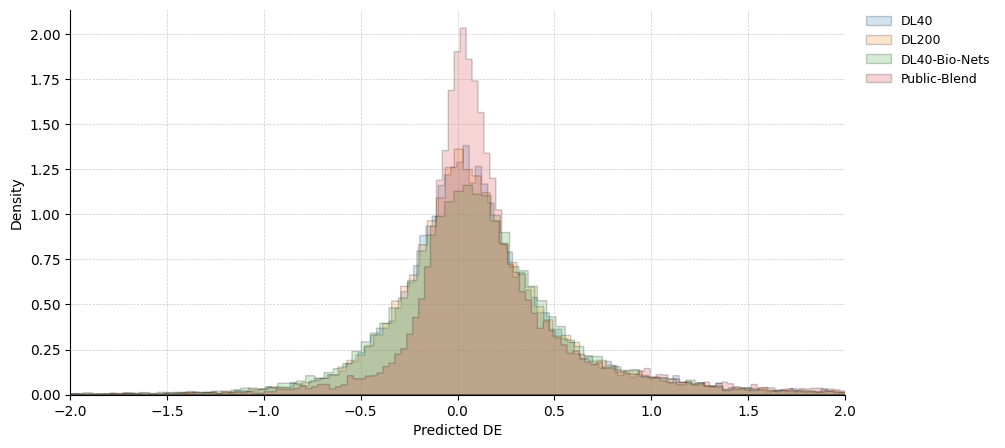

In [5]:
labels = ['DL40', 'DL200', 'DL40-Bio-Nets', 'Public-Blend']
plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 1, 1)
for i in range(len(Y)):
    ys = Y[i, ::300]  # Only take subset of points for faster plotting
    plt.hist(ys, alpha=0.2, bins=1000, density=True, histtype='stepfilled', ec="k", label=labels[i])
plt.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='grey')
ax.spines[['right', 'top']].set_visible(False)
plt.xlim([-2, 2])
prop = {'family': 'Century gothic', 'size': 9}
plt.legend(prop=prop, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)
plt.xlabel('Predicted DE')
plt.ylabel('Density')
plt.show()

We observe that our approaches based on neural networks have more symmetric distributions and produce negative DE values with larger magnitudes.

Let's build a last-minute predictor that we will use in our ensemble as a prior at prevent the final predictions to deviate too much from the training data. This predictor is trivial, as it simply predicts, for each `(cell_type, compound)` pair, a weighted average of samples having either the same `cell_type` or `compound`. To account for the data imbalance (2 random samples are most likely to be of the same cell type than treated with the same compound), we attach different weights to the samples.

In [6]:
# For each (cell_type, compound) pair, we store the weighted mean
# and weighted standard deviation in a dict.
mu_prior = {}
sigma_prior = {}
for sm_name in tqdm.tqdm(unique_sm_names):
    for cell_type in unique_cell_types:
        weights = np.zeros(len(data))
        
        # Re-weight to account for data imbalance
        weights[sm_names == sm_name] = 1.0
        weights[cell_types == cell_type] = 0.1
        
        # Compute weighted averages and weighted standard deviations
        mu_prior[(sm_name, cell_type)] = np.average(data, axis=0, weights=weights)
        sigma_prior[(sm_name, cell_type)] = np.sqrt(np.average(np.square(data - mu_prior[(sm_name, cell_type)][np.newaxis, :]), weights=weights, axis=0))

100%|██████████| 146/146 [02:14<00:00,  1.09it/s]


Let's predict on the test data using this simple predictor.

In [7]:
# Load test set's ID mapping
id_map = []
with open(os.path.join(DATA_FOLDER, 'id_map.csv'), 'r') as f:
    lines = f.readlines()[1:]
    for line in lines:
        id_map.append(line.rstrip().split(',')[1:])
        assert len(id_map[-1]) == 2

# Store the prior means and standard deviations for each row of the test set
Y_prior = []
std_prior = []
for sm_name, cell_type in id_map:
    Y_prior.append(mu_prior[(cell_type, sm_name)])
    std_prior.append(sigma_prior[(cell_type, sm_name)])
Y_prior = np.asarray(Y_prior)
std_prior = np.asarray(std_prior)

The Maximum likelihood-based approach we used to ensemble our models works as follows. Instead of taking a weighted average with fixed weights for all genes, we assumed that some models might perform better for some gene categories. Typically, the contribution of a model to the ensemble for the prediction of a particular gene should be downweighted if this gene is a housekeeping gene, and the model overfitted that gene. To quantify overfitting of each model, we computed the expected value of squared residuals while cross-validating that model. In the present case, we assumed our neural network is unbiased and assumed the normality of residuals. We interpreted the expected value of squared residuals as the variance of the ground-truth DE, with mean equal to the prediction. Let's denote by $y_{ij}$ the ground-truth DE value for sample $i$ and gene $j$, $\hat{y}_{ijm}$ the corresponding prediction by model $m$, and $\hat{\sigma}^2_{jm}$ the variance of that model for gene $j$. The Maximum likelihood estimate for $y_{ij}$, that we denote by $\tilde{y}_{ij}$, is given by:
$$
\begin{align}
    \tilde{y}_{ij} & = \text{argmax}_{\theta} \ \prod_{m} p(\hat{y}_{ijm} \vert \theta, \hat{\sigma}_{jm}) \\
    & = \text{argmin}_{\theta} \ \sum_{m} \left( \frac{\hat{y}_{ijm} - \theta}{\sigma_{jm}} \right)^2 \\
\end{align}
$$
Let's note that $\tilde{y}_{ij}$ has a trivial closed-form solution, given by:
$$
\begin{align}
    \tilde{y}_{ij} & = \frac{\sum_m \frac{\hat{y}_{ijm}}{\sigma_{jm}}}{\sum_m \frac{1}{\sigma_{jm}}}
\end{align}
$$

For each submission, we prealably saved the coefficient of determination $r^2$ for each gene, that we computed while cross-validating each model. However, we are interested in the expected values of squared residuals (variances). Luckily, by definition of $r^2$, we have that $r^2 = 1 - SS_{res} / SS_{tot}$. If $SS_{tot}$ is set to the training set variance, then $SS_{res}$ corresponds to the variance of our predictors.

In [23]:
#r2_jalil = np.load(os.path.join(EXTRA_FOLDER, 'validation-r2-jalil.npy'))
#r2_gbm = np.load(os.path.join(EXTRA_FOLDER, 'validation-r2-gbm.npy'))
#r2_linear = np.load(os.path.join(EXTRA_FOLDER, 'validation-r2-linear.npy'))
r2_dl40 = np.load(os.path.join(EXTRA_FOLDER, 'validation-r2-dl40.npy'))
r2_dl200 = np.load(os.path.join(EXTRA_FOLDER, 'validation-r2-dl200.npy'))
r2_dl_bio_nets = np.load(os.path.join(EXTRA_FOLDER, 'validation-r2-dl-bio-nets.npy'))
r2_all = np.asarray([r2_dl40, r2_dl200, r2_dl_bio_nets])
# NAMES = ['Jalil', 'GBM', 'DL40', 'DL200', 'DL200-Bio-Nets', 'Prior']
NAMES = ['DL40', 'DL200', 'DL200-Bio-Nets', 'Prior']
# dfs = [df_jalil, df_gbm, df_dl40, df_dl200, df_dl_bio_nets]
dfs = [df_dl40, df_dl200, df_dl_bio_nets]
Y = np.asarray([df.to_numpy() for df in dfs])
Y = np.concatenate((Y, Y_prior[np.newaxis, :, :]), axis=0)
print(Y.shape)

# Dataset variances
ss_tot = np.var(data, axis=0, ddof=1)[np.newaxis, :]

# Residual variances
ss_res_all = ss_tot * (1 - r2_all)

# Standard deviations of predictors
sigma = np.tile(np.sqrt(ss_res_all)[:, np.newaxis, :], (1, Y.shape[1], 1))

# Standard deviations of all predictors, including our "prior" method
sigma = np.concatenate((sigma, std_prior[np.newaxis, :, :]), axis=0)
print(sigma.shape)

(4, 255, 18211)
(4, 255, 18211)


Let's look a the predictions (means) and expected values of squared residuals (variances) across models.

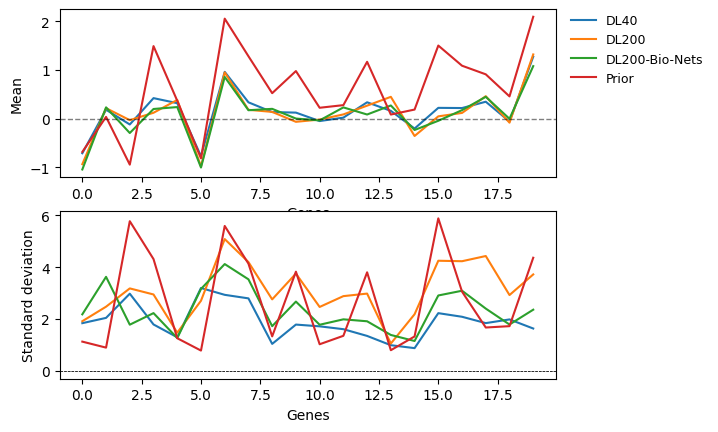

In [24]:
k = 14290  # Look at 20 genes starting from this index
j = 121  # Sample index

# 
plt.subplot(2, 1, 1)
for i in range(len(Y)):
    plt.plot(Y[i, j, k:k+20], label=NAMES[i])
plt.axhline(linestyle='--', linewidth=1, alpha=0.5, color='black')
prop = {'family': 'Century gothic', 'size': 9}
plt.legend(prop=prop, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)
plt.xlabel('Genes')
plt.ylabel('Mean')

plt.subplot(2, 1, 2)
for i in range(len(Y)):
    plt.plot(sigma[i, j, k:k+20], label=NAMES[i])
    plt.axhline(linestyle='--', linewidth=0.5, alpha=0.5, color='black')
plt.xlabel('Genes')
plt.ylabel('DE')
plt.ylabel('Standard deviation')
plt.show()

We now compute the closed-form maximizer for the Gaussian likelihood described above.

In [25]:
numerator = np.sum(Y / np.square(sigma), axis=0)
denominator = np.sum(1 / np.square(sigma), axis=0)
Y_ensemble = numerator / denominator
Y_ensemble.shape

(255, 18211)

If the coefficient of determination $r^2$ is negative for all models (they are all doing worse than random), we alleviate risks of introducing outliers by replacing the prediction by the median across all models.

In [26]:
mask = (np.max(r2_all, axis=0) < 0)
Y_ensemble[:, mask] = np.median(data, axis=0)[mask]
np.sum(mask)

640

And we write the solutions to a Pandas dataframe.

In [27]:
df_ensemble = df_dl40.copy()
df_ensemble.loc[:, :] = Y_ensemble

(4, 4)


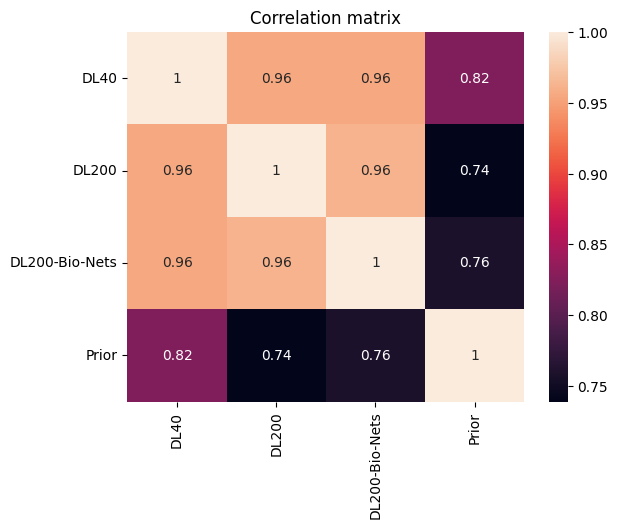

In [28]:
corr = np.corrcoef(Y.reshape(len(Y), -1))
print(corr.shape)
seaborn.heatmap(corr, annot=True)
plt.xticks(0.5 + np.arange(len(NAMES)), NAMES, rotation=90)
plt.yticks(0.5 + np.arange(len(NAMES)), NAMES, rotation=0)
plt.title('Correlation matrix')
plt.show()

In [29]:
signs = np.sign(Y)
print('The signs of the predictors all match in that fraction of the cases:')
np.mean(np.all(signs[0, np.newaxis, ...] == signs, axis=0))

The signs of the predictors all match in that fraction of the cases:


0.7003175197924978

Let's compare our predictors 2-by-2 to see to what extent they agree:

In [30]:
def compare_submissions(i, j):
    fig = plt.figure(figsize=(12, 6))
    ax = plt.subplot(1, 2, 1)
    xs = Y[i, :128].flatten()
    ys = Y[j, :128].flatten()
    #xs = Y[i, 147]
    #ys = Y[j, 147]
    plt.scatter(xs, ys, alpha=0.05)
    ax.spines[['right', 'top']].set_visible(False)
    ax.grid(linestyle='--', linewidth=0.5, color='grey', alpha=0.4)
    ax.set_xlabel(NAMES[i])
    ax.set_ylabel(NAMES[j])
    ax.set_xlim([-40, 70])
    ax.set_ylim([-40, 50])
    ax.set_title('B cells')
    ax.plot([-40, 40], [-40, 40], linestyle='--', color='black')

    ax = plt.subplot(1, 2, 2)
    xs = Y[i, 128:].flatten()
    ys = Y[j, 128:].flatten()
    #xs = Y[i, 149]
    #ys = Y[j, 149]
    plt.scatter(xs, ys, alpha=0.05)
    ax.spines[['right', 'top']].set_visible(False)
    ax.grid(linestyle='--', linewidth=0.5, color='grey', alpha=0.4)
    ax.set_xlabel(NAMES[i])
    ax.set_ylabel(NAMES[j])
    ax.set_xlim([-40, 70])
    ax.set_ylim([-40, 50])
    ax.set_title('Myeloid cells')
    ax.plot([-40, 40], [-40, 40], linestyle='--', color='black')
    plt.show()

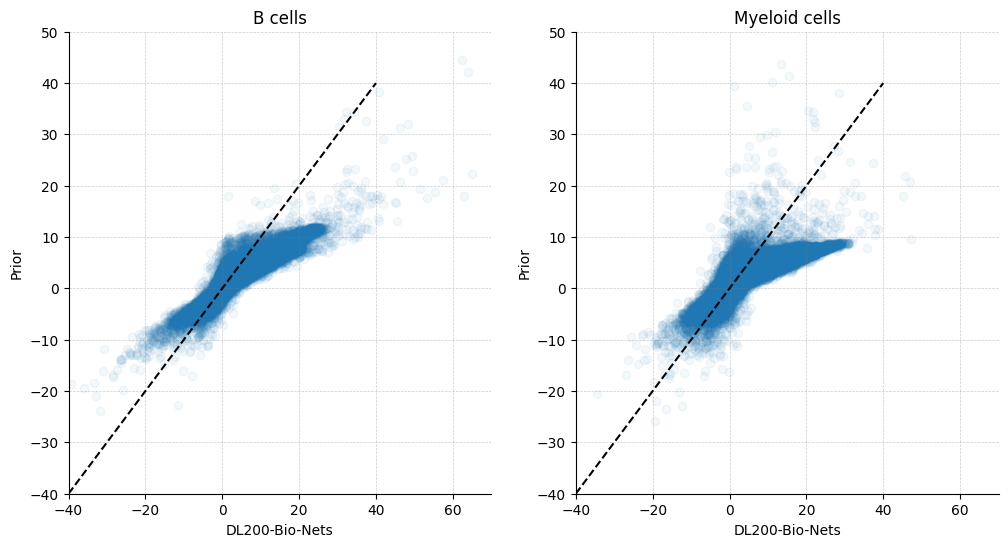

In [31]:
compare_submissions(2, 3)

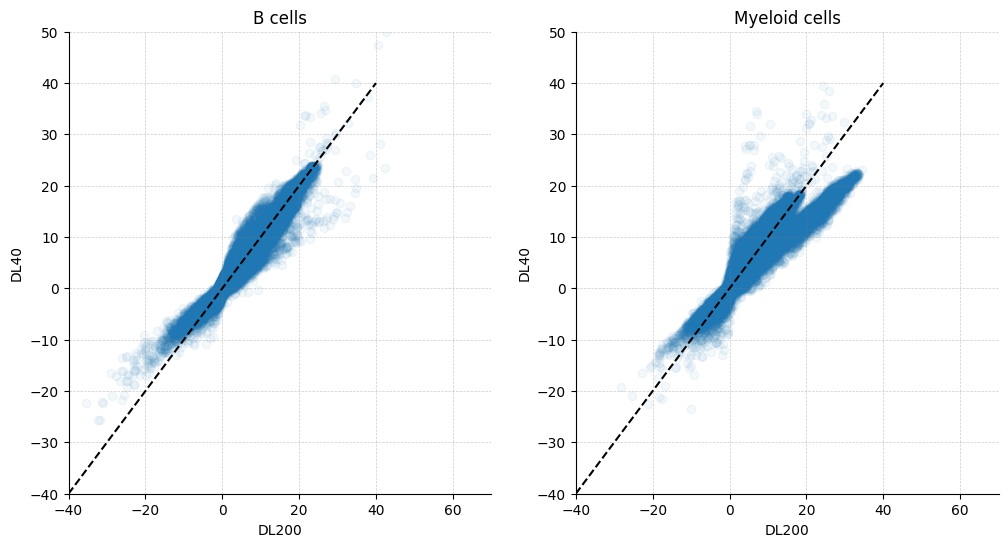

In [32]:
compare_submissions(1, 0)

Finally we compare, for each model, how to fits the null distribution:

In [33]:
def background_noise(*size: int, cutoff: float = 1e-7) -> np.ndarray:
    """Generates random DE values under the null hypothesis.
    
    In the absence of any biological signal, p-values can be expected to be 
    uniformly distributed. Also, poitive and negative DE values are equally likely.
    
    Args:
        size: shape of the output tensor.
        cutoff: Significance threshold used to make sure we don't introduce huge outliers in the data.
            This cutoff does not have a real statistical meaning, and is only meant for numerical stability.
            P-values will be randomly and uniformly sampled from the ``[cutoff, 1]`` interval.
    """
    sign = 2 * np.random.randint(0, 2, size) - 1
    return sign * np.log10(cutoff + np.random.rand(*size) * (1. - cutoff))

In [34]:
def compare_against_background(i: int) -> None:
    """Plot histogram of the DE predictions for method `i`,
    and compare it to a histogram of random values drawn from the null distribution.
    
    Args:
        i: Index of the method in matrix `Y`.
    """
    fig = plt.figure(figsize=(12, 6))
    ax = plt.subplot(1, 1, 1)
    ax.hist(background_noise(10000), bins=200, density=True, alpha=0.4, label='Background noise')
    ys = Y[i].flatten()
    ys = ys[np.abs(ys) < 5]  # For visibility purposes
    ax.hist(ys, bins=200, density=True, alpha=0.4, label='Estimated DE')
    ax.set_xlabel(f'DE ({NAMES[i]})')
    ax.set_ylabel('Density')
    ax.set_xlim([-5, 5])
    ax.spines[['right', 'top']].set_visible(False)
    ax.grid(linestyle='--', linewidth=0.5, color='grey', alpha=0.4)
    ax.legend()
    plt.show()

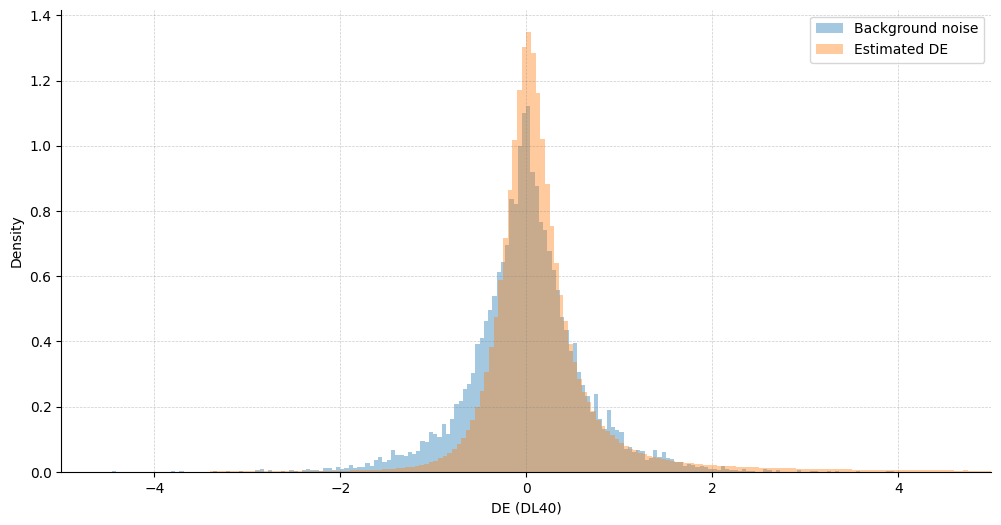

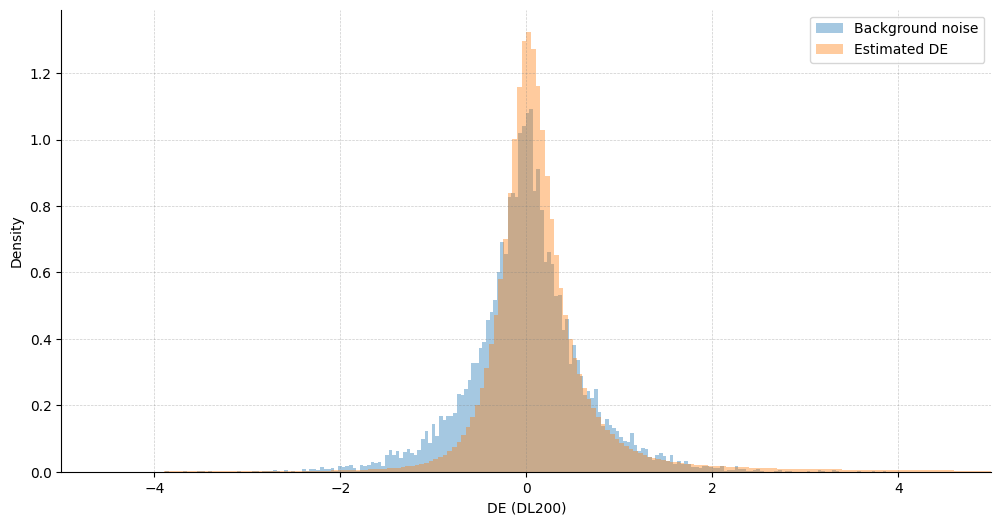

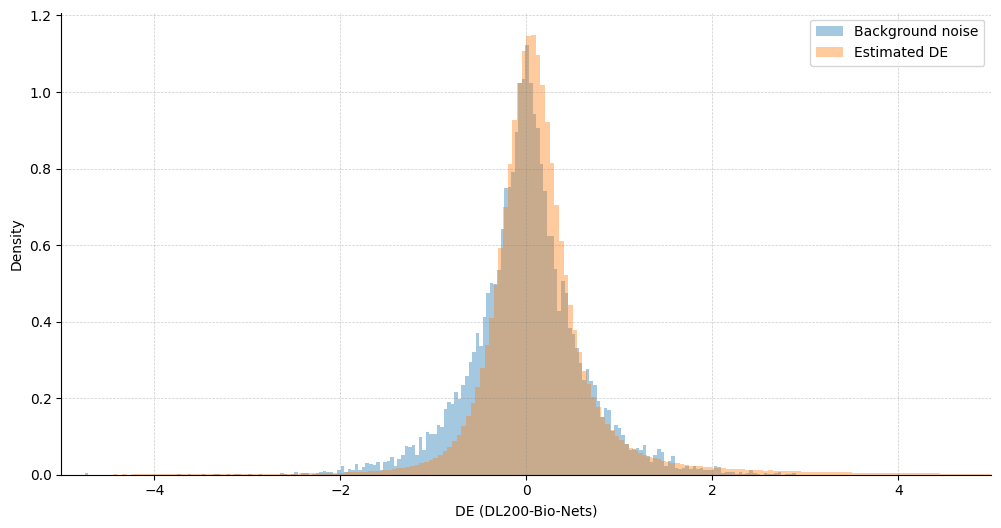

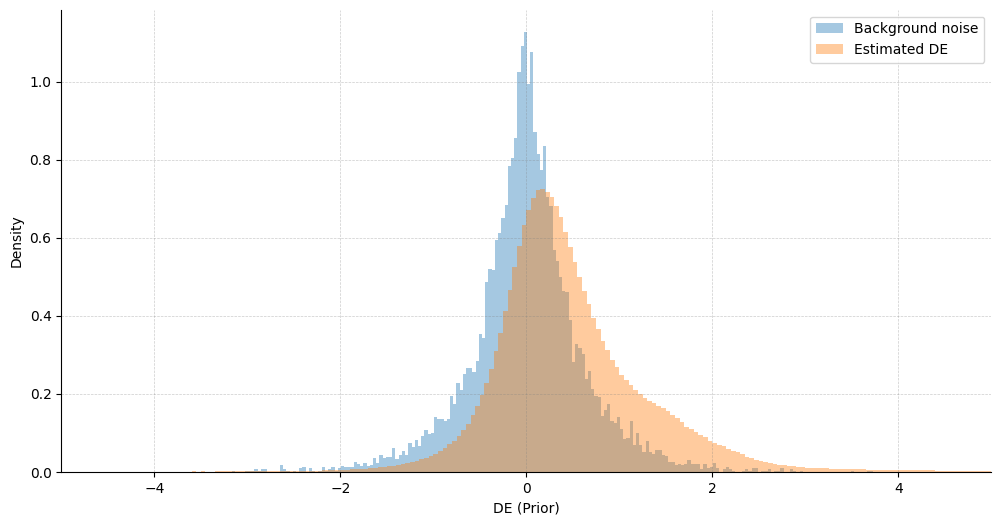

In [35]:
for i in range(len(NAMES)):
    compare_against_background(i)

Finally, we soft-clip the predictions if they exceed the ranges observed in the training data.

In [36]:
# Convert final predictions to NumPy array for simplicity
final_pred = df_ensemble.to_numpy()

# Remove left-over outliers in predictions
lb = np.min(data, axis=0)
ub = np.max(data, axis=0)
for i in range(len(final_pred)):
    mask = (final_pred[i, :] > ub)
    final_pred[i, mask] = ub[mask] + 0.0024 * (final_pred[i, mask] - ub[mask])
    mask = (final_pred[i, :] < lb)
    final_pred[i, mask] = lb[mask] - 0.0024 * np.abs(lb[mask] - final_pred[i, mask])

Create final submission.

In [37]:
df_ensemble.loc[:, :] = final_pred
df_ensemble.to_csv('submission.csv')